In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import statsmodels.formula.api as smf
import sklearn
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import sys

In [6]:
alpha = 0.7

In [9]:
df0 = pd.read_csv("suicide_data.csv")
df0.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


DATA CLEANING

In [10]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
country               27820 non-null object
year                  27820 non-null int64
sex                   27820 non-null object
age                   27820 non-null object
suicides_no           27820 non-null int64
population            27820 non-null int64
suicides/100k pop     27820 non-null float64
country-year          27820 non-null object
HDI for year          8364 non-null float64
 gdp_for_year ($)     27820 non-null object
gdp_per_capita ($)    27820 non-null int64
generation            27820 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [11]:
df0['country'].nunique()

101

* Make the colunm name more clean and succinct 

In [13]:
df0.rename(columns={'suicides_no':'suicides', 'suicides/100k pop':'suicides/100k',\
                   ' gdp_for_year ($) ':'gdp/year ', 'gdp_per_capita ($)':'gdp/capita'}, inplace=True)
df0.head()

,country,year,sex,age,suicides,population,suicides/100k,country-year,HDI for year,gdp/year,gdp/capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


* Delete countries whose data size are less than 50

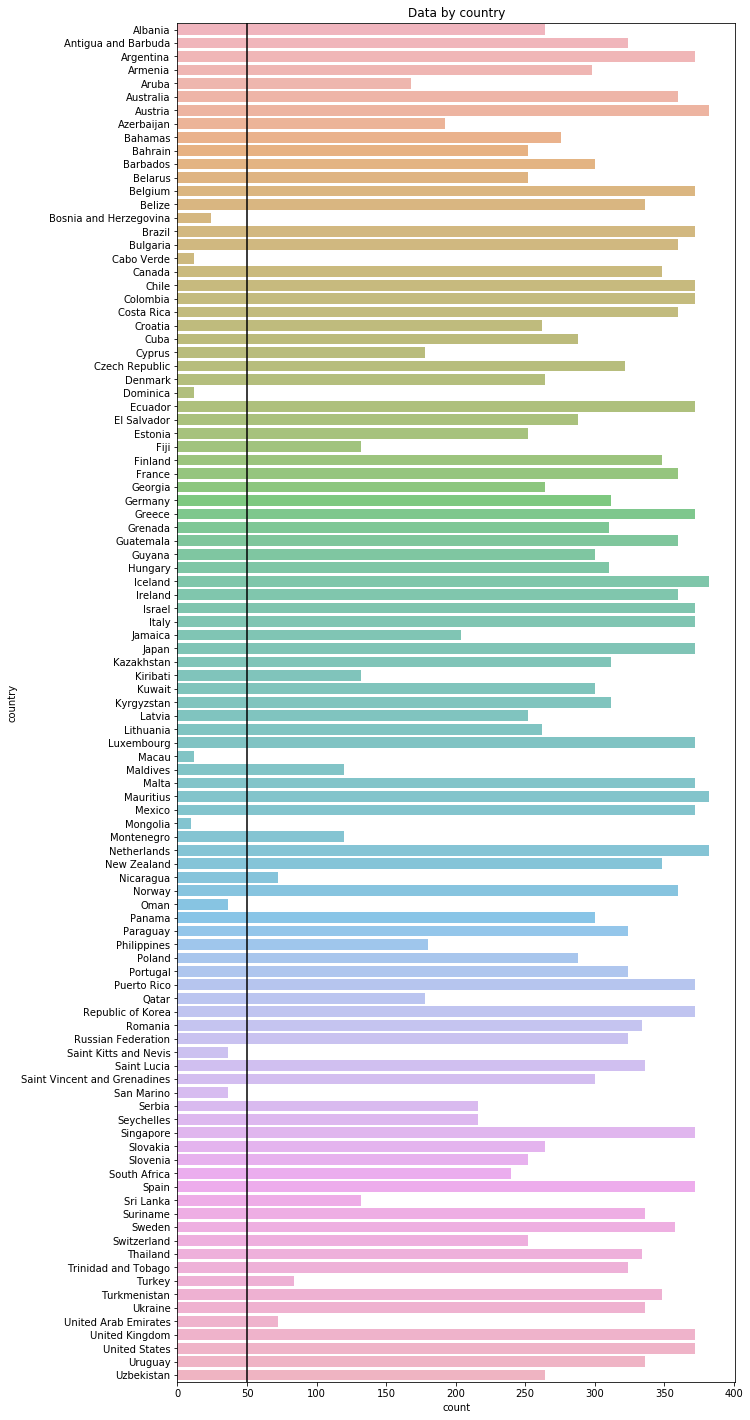

In [14]:
plt.figure(figsize=(10,25))
sns.countplot(y='country', data=df0, alpha=alpha)
plt.title('Data by country')
plt.axvline(x=50, color='k')
plt.show()

In [15]:
country_amountData = df0.groupby('country').count()['year'].reset_index()
country_amountData.sort_values(by='year', ascending=True). head(10)

,country,year
59,Mongolia,10
27,Dominica,12
54,Macau,12
17,Cabo Verde,12
14,Bosnia and Herzegovina,24
65,Oman,36
76,Saint Kitts and Nevis,36
79,San Marino,36
96,United Arab Emirates,72
63,Nicaragua,72


In [16]:
# delete top 8 countires from above that are less then 50
country_selectList = country_amountData[country_amountData['year'] > 50]['country'].reset_index()

In [18]:
df1 = pd.merge(df0, country_selectList, how='outer', indicator=True)
df1 = df1[df1['_merge']=='both']
df1.nunique()

country             93
year                32
sex                  2
age                  6
suicides          2084
population       25440
suicides/100k     5294
country-year      2306
HDI for year       305
gdp/year          2306
gdp/capita        2219
generation           6
index               93
_merge               1
dtype: int64

In [19]:
# we have 93 countries now from the original 101 to be considered in our analysis

* Delete the years whose data are significantly less than others', such as less than 200

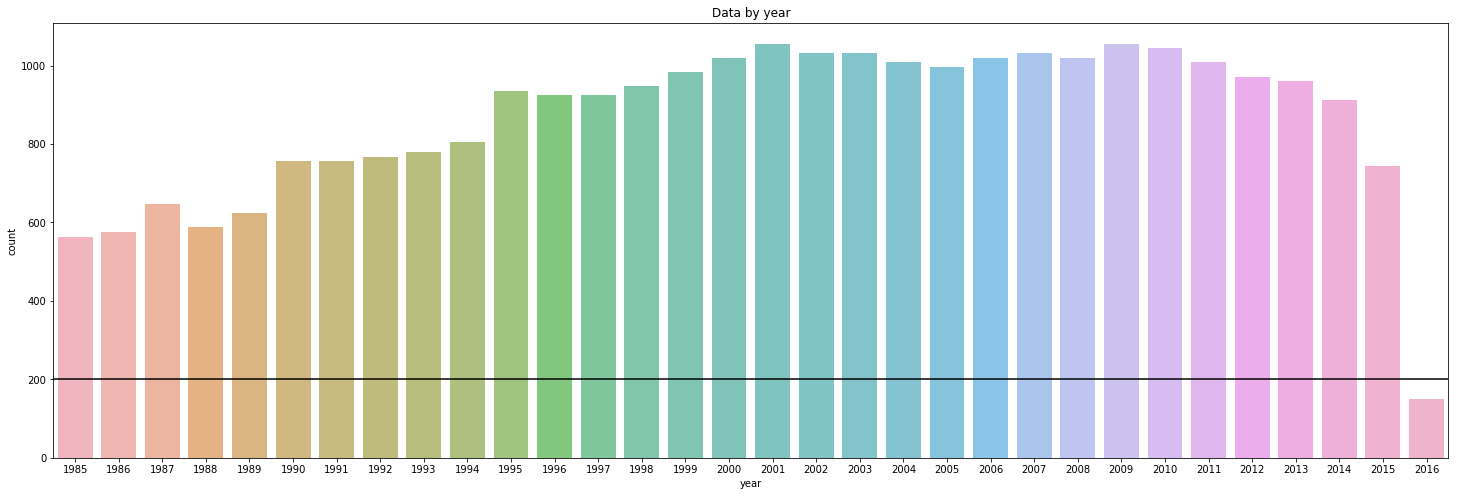

In [20]:
plt.figure(figsize=(25,8))
sns.countplot(x='year', data=df1, alpha=alpha)
plt.title('Data by year')
plt.axhline(y=200, color='k')
plt.show()

In [23]:
df2 = df1[df1['year'] != 2016]

* Delete the coloumns that have sinificantly many missing data

In [24]:
number_NAN = len(df2) - df2['HDI for year'].count()
number_noNAN = len(df2)
number_NAN * 100 / number_noNAN

69.75120034919249

In [26]:
# Around 70% of the values in that columns are Nan's. Therefore, I deleted this column

In [27]:
df3 = df2.drop('HDI for year', axis=1)
df3.head()

,country,year,sex,age,suicides,population,suicides/100k,country-year,gdp/year,gdp/capita,generation,index,_merge
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,"2,156,624,900",796,Generation X,0.0,both
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,"2,156,624,900",796,Silent,0.0,both
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,"2,156,624,900",796,Generation X,0.0,both
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,"2,156,624,900",796,G.I. Generation,0.0,both
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,"2,156,624,900",796,Boomers,0.0,both


DATA MERGING - regime (level of political freedom) of the country

In [28]:
regime = pd.read_csv("regime.csv")
regime = regime.rename(columns={'Entity': 'country', 'Year': 'year'})
regime.head()

,country,Code,year,Political regime type (Score),Human rights protection score,Total population (Gapminder)
0,Afghanistan,AFG,1800,NaN,NaN,3280000.0
1,Afghanistan,AFG,1816,-6.0,NaN,NaN
2,Afghanistan,AFG,1817,-6.0,NaN,NaN
3,Afghanistan,AFG,1818,-6.0,NaN,NaN
4,Afghanistan,AFG,1819,-6.0,NaN,NaN


In [33]:
df = pd.merge(df3, regime, how = 'inner', on = ['year', 'country'])
df.head()

,country,year,sex,age,suicides,population,suicides/100k,country-year,gdp/year,gdp/capita,generation,index,_merge,Code,Political regime type (Score),Human rights protection score,Total population (Gapminder)
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,"2,156,624,900",796,Generation X,0.0,both,ALB,-9.0,-0.535241,3116009.0
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,"2,156,624,900",796,Silent,0.0,both,ALB,-9.0,-0.535241,3116009.0
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,"2,156,624,900",796,Generation X,0.0,both,ALB,-9.0,-0.535241,3116009.0
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,"2,156,624,900",796,G.I. Generation,0.0,both,ALB,-9.0,-0.535241,3116009.0
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,"2,156,624,900",796,Boomers,0.0,both,ALB,-9.0,-0.535241,3116009.0


DATA ANALYSIS

* Suicide by country

In [34]:
byCountry = df.groupby('country').mean().sort_values('suicides/100k', ascending=False).reset_index()

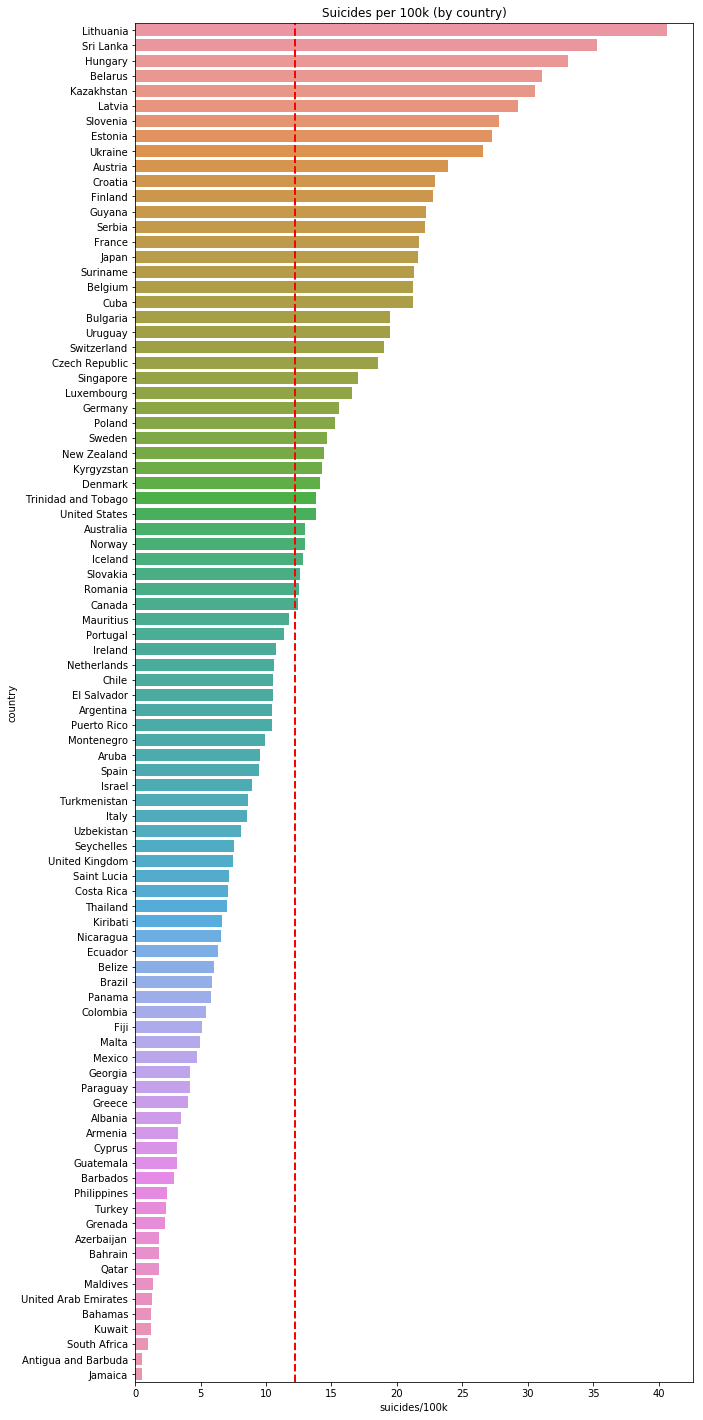

In [35]:
plt.figure(figsize=(10,25))
sns.barplot(x='suicides/100k', y ='country', data=byCountry)
plt.axvline(x = byCountry['suicides/100k'].mean(),color = 'red', ls='--', linewidth=2)
plt.title('Suicides per 100k (by country)')
plt.show()

* Suicide by year

In [36]:
byYear = df.groupby('year').mean().reset_index()

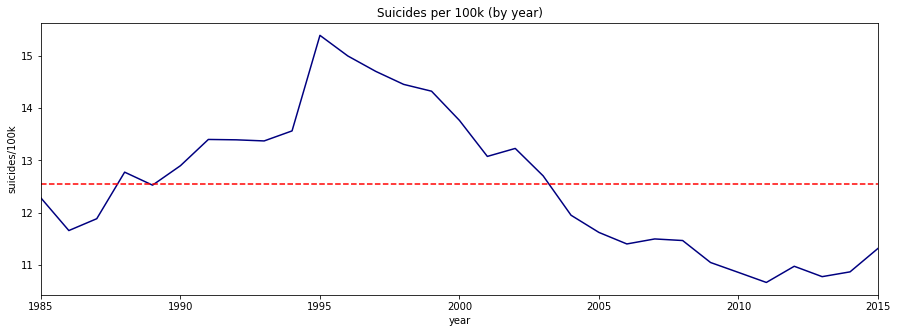

In [37]:
plt.figure(figsize=(15,5))
sns.lineplot(x='year', y='suicides/100k', data=byYear, color='navy')
plt.axhline(byYear['suicides/100k'].mean(), ls='--', color='red')
plt.title('Suicides per 100k (by year)')
plt.xlim(1985,2015)
plt.show()

* Suicide by sex

In [42]:
bySex     = df.groupby('sex').mean().reset_index()
bySexYear = df.groupby(['sex','year']).mean().reset_index()
bySexAge = df.groupby(['sex','age']).mean().sort_values('suicides/100k', ascending=True).reset_index()
bySexGeneration = df.groupby(['sex','generation']).mean().sort_values('suicides/100k', ascending=True).reset_index()

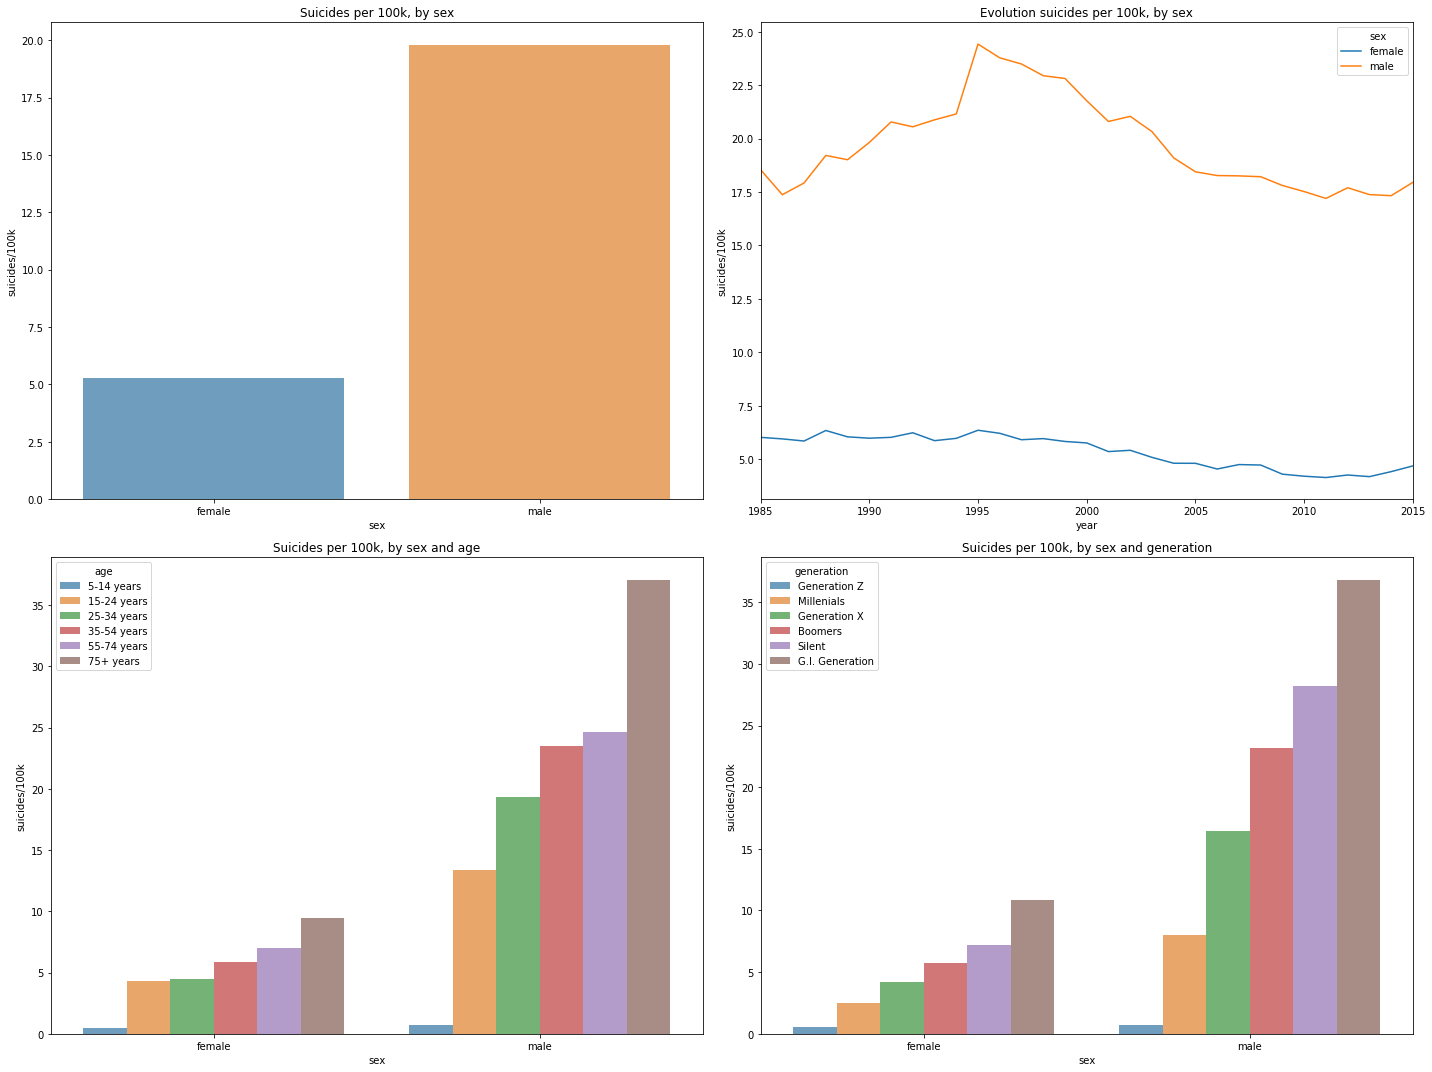

In [43]:
plt.figure(figsize=(20,15))
# By sex
plt.subplot(221)
sns.barplot(x='sex', y='suicides/100k', data=bySex, alpha=alpha)
plt.title('Suicides per 100k, by sex')
# Time veolution by sex
plt.subplot(222)
sns.lineplot(x='year', y='suicides/100k', data=bySexYear, hue='sex')
plt.xlim(1985,2015)
plt.title('Evolution suicides per 100k, by sex')
# By sex and age
plt.subplot(223)
sns.barplot(x='sex', y='suicides/100k', data=bySexAge, hue='age', alpha=alpha)
plt.title('Suicides per 100k, by sex and age')
# By sex and generation
plt.subplot(224)
sns.barplot(x='sex', y='suicides/100k', data=bySexGeneration, hue='generation', alpha=alpha)
plt.title('Suicides per 100k, by sex and generation')

plt.tight_layout()
plt.show()

C:\Users\Rodney_NB\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


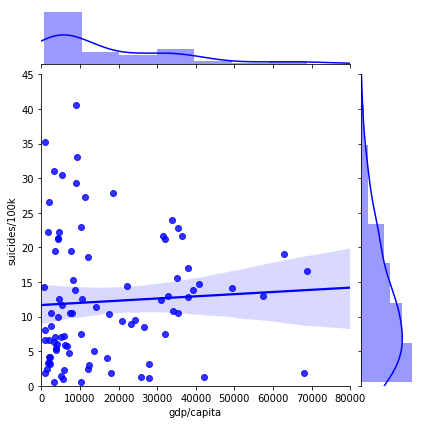

In [38]:
g = sns.jointplot(x="gdp/capita", y="suicides/100k", data=byCountry, kind='regresion', \
              xlim=(-100,80000), ylim=(0,45), color='blue')

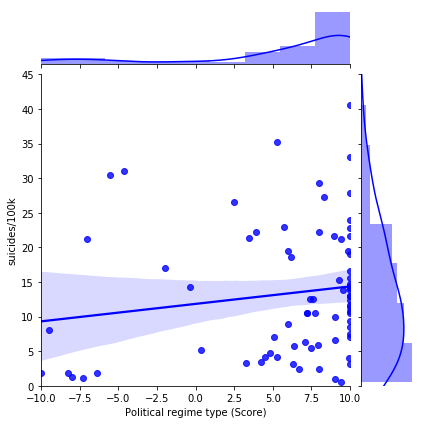

In [40]:
g = sns.jointplot(x="Political regime type (Score)", y="suicides/100k", data=byCountry, kind='regresion', \
              xlim=(-10,10), ylim=(0,45), color='blue')

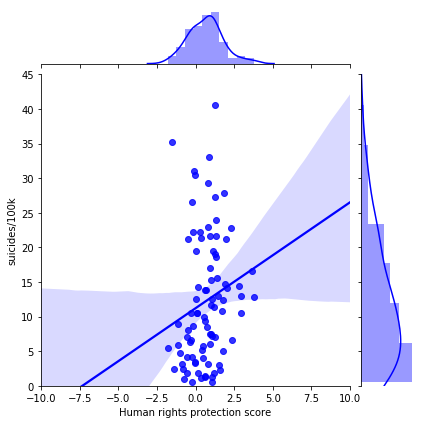

In [41]:
g = sns.jointplot(x="Human rights protection score", y="suicides/100k", data=byCountry, kind='regresion', \
              xlim=(-10,10), ylim=(0,45), color='blue')